## Mini-Projeto 4

### Prevendo Customer Churn em Operadoras de Telecom

customer churn refere-se a rotatividade de clientes na empresa. Nesse projeto queremos prever se um cliente irá sair da empresa ou não e buscar identificar o motivo da saída do mesmo. 

In [1]:
# Bibliotecas base
import pandas as pd
import numpy as np

# Bibliotecas para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para seleção de atributos
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

# Biblioteca para pré-processar os dados
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder

# Biblitecas para separar e treinar os dados
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression

# Biblioteca para balancear os dados
from imblearn.over_sampling import SMOTE

# Bibliotecas para avaliar a performance do modelo
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn import metrics 

Using TensorFlow backend.


In [2]:
# Definindo as funções
def ResumeDados(data):
    """
    Resume as porcentagens de valores missings e os tipos das colunas em um dataframe.
    
    param data: Dataframe para sumarizar os dados
    
    returns: dataFrame com valores missings.
    """
    
    tipos = data.dtypes
    missingValues = data.isna().sum().sort_values(ascending=False)
    dfMissingValues = pd.DataFrame({"Tipo": tipos,
                                    "NumValorMissing": missingValues,
                                    "PorcentagemValorMissing(%)": (round((missingValues/data.shape[0])*100, 2))})

    dfMissingValues = dfMissingValues[dfMissingValues["PorcentagemValorMissing(%)"] > 0]
    
    return dfMissingValues

def heatMap(data):
    """
    Imprime o heatmap de correlação.
    
    param data: Dataframe para plotar o heatmap.
    """
    
    corr = data.corr()

    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    f, ax = plt.subplots(figsize=(18, 15))

    sns.heatmap(corr, mask=mask, cmap='RdBu', vmax=.3, fmt='.2f', annot=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_curveROC(y_real, y_pred):
    """
    Imprime uma curva ROC.
    
    param y_real: Variável com o valor histórico dos dados.
    param y_pred: Variável com o valor previsto pelo modelo.
    
    """
    fpr, tpr, _ = metrics.roc_curve(y_real,  y_pred)
    auc = metrics.roc_auc_score(y_real, y_pred)
    
    plt.figure(figsize=(12,8))
    plt.title("AUC = " + str(round(auc, 2)))
    plt.plot(fpr, tpr, label='AUC')
    plt.plot([0,1], [0,1], c='red')
    plt.legend()
    plt.show()
    
# def previsao(x):
#     """
#     Mostra em um formato mais acessível a previsão do modelo.
    
#     param x: Variável com o perfil do cliente.
    
#     return: dataframe com a informação
#     """
#     retorno = []
#     for features in x:
#         probs = modelo.predict_proba(x)
#         indice = np.argmax(probs)
#         prob = round((probs[0][indice])*100, 2)
#         if indice == 0:
#             retorno.append(("Cliente sai da empresa", str(prob) + "%"))
#         else:
#             retorno.append(("Cliente não sai da empresa", str(prob) + "%"))
        
#     return pd.DataFrame(retorno, columns=['churn', 'Probabilidade'])

### Carregando os dados

In [3]:
datasetTreino = pd.read_csv("../Dados/projeto4_telecom_treino.csv")
datasetTeste = pd.read_csv("../Dados/projeto4_telecom_teste.csv")

datasetTreino.drop(['Unnamed: 0'], axis = 1, inplace = True)
datasetTeste.drop(['Unnamed: 0'], axis = 1, inplace = True)

## Análise exploratória

Na análise exploratória procuraremos por correlação entre os dados, qual o formato deles, outliers e afins.

In [4]:
datasetTreino.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [5]:
datasetTeste.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,HI,101,area_code_510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
1,MT,137,area_code_510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
2,OH,103,area_code_408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
3,NM,99,area_code_415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
4,SC,108,area_code_415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


In [6]:
print("shape dos dados de treino = ", (datasetTreino.shape))
print("shape dos dados de teste = ", (datasetTeste.shape))

shape dos dados de treino =  (3333, 20)
shape dos dados de teste =  (1667, 20)


In [7]:
ResumeDados(datasetTreino)

,Tipo,NumValorMissing,PorcentagemValorMissing(%)


In [8]:
ResumeDados(datasetTeste)

,Tipo,NumValorMissing,PorcentagemValorMissing(%)


In [9]:
datasetTreino.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [10]:
datasetTreino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3333 non-null   object 
 1   account_length                 3333 non-null   int64  
 2   area_code                      3333 non-null   object 
 3   international_plan             3333 non-null   object 
 4   voice_mail_plan                3333 non-null   object 
 5   number_vmail_messages          3333 non-null   int64  
 6   total_day_minutes              3333 non-null   float64
 7   total_day_calls                3333 non-null   int64  
 8   total_day_charge               3333 non-null   float64
 9   total_eve_minutes              3333 non-null   float64
 10  total_eve_calls                3333 non-null   int64  
 11  total_eve_charge               3333 non-null   float64
 12  total_night_minutes            3333 non-null   f

Os modelos de machine learning não 'conhecem' textos, por isso mais a frente vamos transformar as variáveis categóricas para números.

In [11]:
datasetTreino.select_dtypes(['object'])

,state,area_code,international_plan,voice_mail_plan,churn
0,KS,area_code_415,no,yes,no
1,OH,area_code_415,no,yes,no
2,NJ,area_code_415,no,no,no
3,OH,area_code_408,yes,no,no
4,OK,area_code_415,yes,no,no
...,...,...,...,...,...
3328,AZ,area_code_415,no,yes,no
3329,WV,area_code_415,no,no,no
3330,RI,area_code_510,no,no,no
3331,CT,area_code_510,yes,no,no


A coluna `state` tem muitos valores únicos. Por isso, talvez seja melhor excluí-la do modelo.

In [12]:
datasetTreino['state'].value_counts()

WV    106
MN     84
NY     83
AL     80
OH     78
WI     78
OR     78
WY     77
VA     77
CT     74
MI     73
VT     73
ID     73
UT     72
TX     72
IN     71
KS     70
MD     70
NJ     68
MT     68
NC     68
CO     66
WA     66
NV     66
MS     65
RI     65
MA     65
AZ     64
MO     63
FL     63
ND     62
ME     62
NM     62
NE     61
OK     61
DE     61
SD     60
SC     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
TN     53
HI     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: state, dtype: int64

In [13]:
datasetTreino['area_code'].value_counts()

area_code_415    1655
area_code_510     840
area_code_408     838
Name: area_code, dtype: int64

Vemos que nossa variável target `churn` está __desbalanceada__ algo que teremos que tratar.

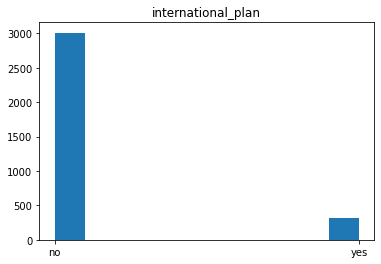

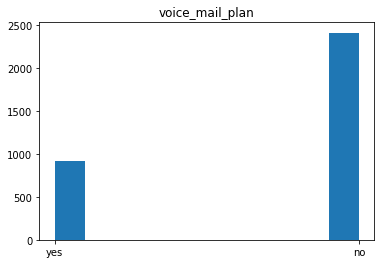

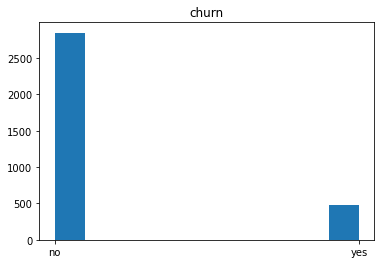

In [14]:
cols = ["international_plan", "voice_mail_plan", "churn"]

for col in cols:
    plt.title(col)
    plt.hist(datasetTreino[col])
    plt.show()

Vamos fazer uma tabela cruzada só para verificar se há alguma correlação clara ou algum insight

In [15]:
pd.crosstab(datasetTreino['voice_mail_plan'], datasetTreino['churn'])

churn,no,yes
voice_mail_plan,,
no,2008,403
yes,842,80


In [16]:
pd.crosstab(datasetTreino['international_plan'], datasetTreino['churn'])

churn,no,yes
international_plan,,
no,2664,346
yes,186,137


In [17]:
pd.crosstab(datasetTreino['state'], datasetTreino['churn']).sort_values(by="yes", ascending = False)

churn,no,yes
state,,
NJ,50,18
TX,54,18
MD,53,17
MI,57,16
MN,69,15
NY,68,15
MT,54,14
NV,52,14
MS,51,14


Plotando alguns gráficos para ver se achamos alguma relação.

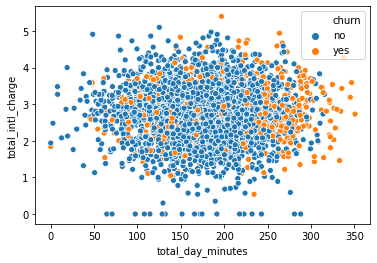

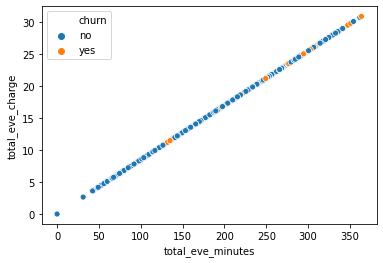

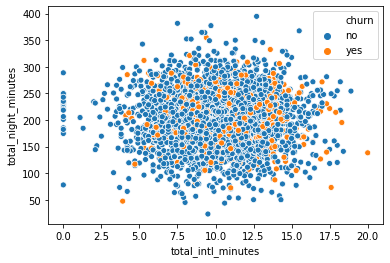

In [18]:
ax = sns.scatterplot(x="total_day_minutes", y="total_intl_charge", hue="churn", data=datasetTreino)
plt.show()

ax = sns.scatterplot(x="total_eve_minutes", y="total_eve_charge", hue="churn", data=datasetTreino)
plt.show()

ax = sns.scatterplot(x="total_intl_minutes", y="total_night_minutes", hue="churn", data=datasetTreino)
plt.show()

In [19]:
datasetTreino.select_dtypes(['float'])

,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge
0,265.1,45.07,197.4,16.78,244.7,11.01,10.0,2.70
1,161.6,27.47,195.5,16.62,254.4,11.45,13.7,3.70
2,243.4,41.38,121.2,10.30,162.6,7.32,12.2,3.29
3,299.4,50.90,61.9,5.26,196.9,8.86,6.6,1.78
4,166.7,28.34,148.3,12.61,186.9,8.41,10.1,2.73
...,...,...,...,...,...,...,...,...
3328,156.2,26.55,215.5,18.32,279.1,12.56,9.9,2.67
3329,231.1,39.29,153.4,13.04,191.3,8.61,9.6,2.59
3330,180.8,30.74,288.8,24.55,191.9,8.64,14.1,3.81
3331,213.8,36.35,159.6,13.57,139.2,6.26,5.0,1.35


In [20]:
datasetTreino.select_dtypes(['float', 'int'])

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2
3329,68,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3
3330,28,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2
3331,184,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2


Para facilitar a busca por correlação vamos converter os dados categóricos para numéricos para plotar uma mapa de calor.

As colunas `international_plan`, `voice_mail_plan` e `churn` tem valores lógicos como string. Vamos usar o padrão <br>
0 - no <br>
1 - yes

In [21]:
for col in cols:
    datasetTreino[col] = datasetTreino[col].apply(lambda x: 0 if x == "no" else 1)
    datasetTeste[col] = datasetTeste[col].apply(lambda x: 0 if x == "no" else 1)

Usaremos a função labelEnconder para facilitar a conversão de categório para inteiro.

In [22]:
encoder = LabelEncoder()

for col in ["state", "area_code"]:
    values = encoder.fit_transform(datasetTreino[col])
    values2 = encoder.fit_transform(datasetTeste[col])
    
    datasetTreino[col] = values
    datasetTeste[col] = values2

In [23]:
# Não há mais nenhum valor object
print(any(datasetTreino.select_dtypes(['object'])))
print(any(datasetTeste.select_dtypes(['object'])))

False
False


Usaremos o mapa de calor para visualizar melhor a correlação entre as variáveis. É visível que algumas variáveis não possuem correlação __linear__ com a variável alvo.  

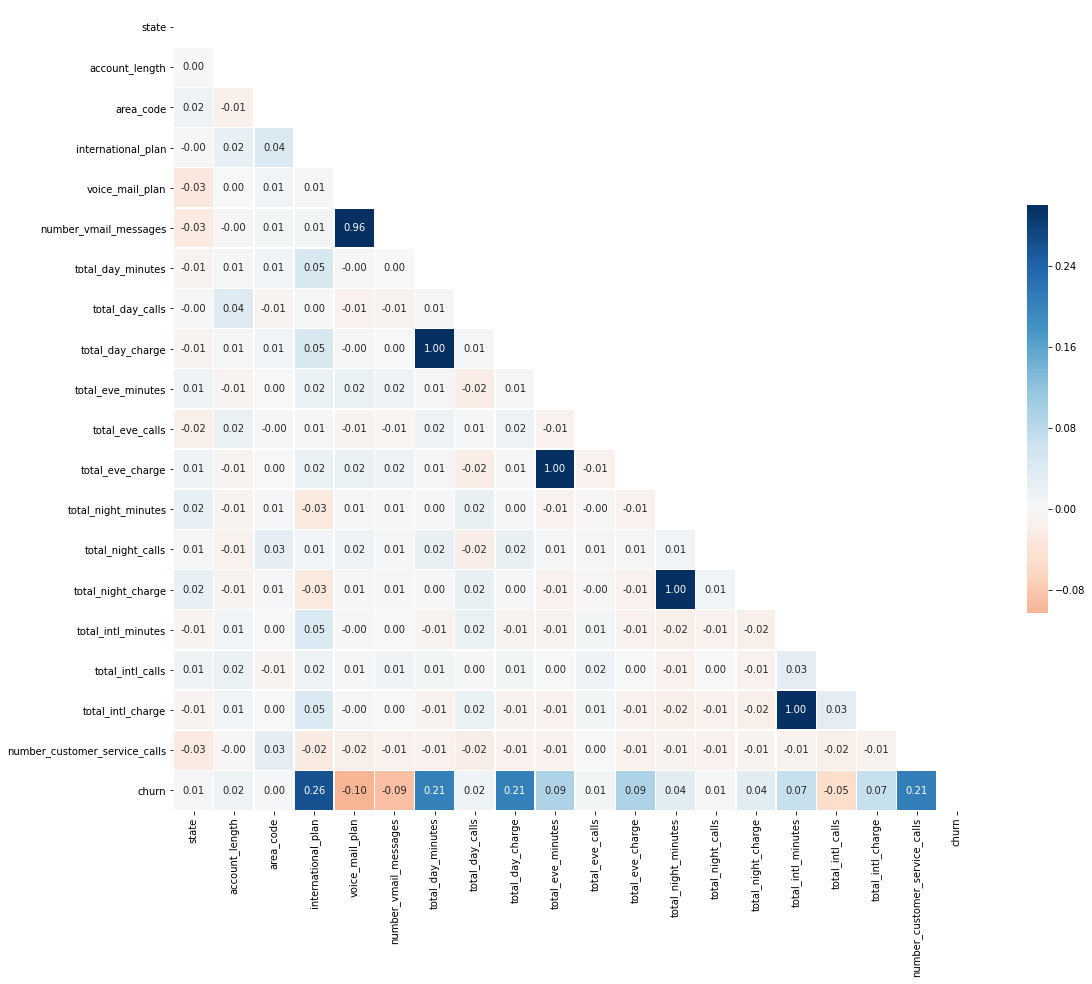

In [24]:
heatMap(datasetTreino)

Agora usaremos duas técnica de feature selection como outro método para escolher as melhores variáveis para o modelo.  

In [25]:
k = 7
selectFeature = SelectKBest(score_func=f_classif, k=k)
kbest = selectFeature.fit_transform(datasetTreino.drop(['churn'], axis = 1), datasetTreino['churn'])
bestColumns1 = datasetTreino.drop(['churn'], axis = 1).iloc[:,selectFeature.get_support() == True]

In [26]:
selector = SelectFromModel(estimator=LogisticRegression(), max_features=k, threshold=-np.inf)
bestFeatures = selector.fit_transform(datasetTreino.drop(['churn'], axis = 1), datasetTreino['churn'])
bestColumns2 = datasetTreino.drop(['churn'], axis = 1).iloc[:, selector.get_support() == True]

/home/breno/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
bestColumns2.columns

Index(['area_code', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_night_calls', 'total_intl_calls',
       'number_customer_service_calls'],
      dtype='object')

Os métodos indicaram algumas colunas diferentes, então vou pegar as colunas diferentes de cada modelo e explorá-las

In [28]:
melhoresColunas = list(set(list(bestColumns1) + list(bestColumns2.columns)))
melhoresColunas.append('churn')

Antes de padronizar vamos procurar por outliers. Para facilitar a busca vou separar as colunas por tipo.

In [29]:
colunasFloat = datasetTreino[melhoresColunas].select_dtypes(['float']).columns
colunasInt = ["number_customer_service_calls", "total_eve_calls", "total_day_calls", "total_night_calls",
             "number_vmail_messages","area_code","total_intl_calls"]

In [30]:
datasetTreino[melhoresColunas].describe()

,total_night_calls,total_eve_minutes,voice_mail_plan,international_plan,total_day_charge,total_eve_charge,area_code,total_intl_calls,total_day_minutes,number_customer_service_calls,number_vmail_messages,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,100.107711,200.980348,0.276628,0.096910,30.562307,17.083540,1.000600,4.479448,179.775098,1.562856,8.099010,0.144914
std,19.568609,50.713844,0.447398,0.295879,9.259435,4.310668,0.709649,2.461214,54.467389,1.315491,13.688365,0.352067
min,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,87.000000,166.600000,0.000000,0.000000,24.430000,14.160000,0.000000,3.000000,143.700000,1.000000,0.000000,0.000000
50%,100.000000,201.400000,0.000000,0.000000,30.500000,17.120000,1.000000,4.000000,179.400000,1.000000,0.000000,0.000000
75%,113.000000,235.300000,1.000000,0.000000,36.790000,20.000000,2.000000,6.000000,216.400000,2.000000,20.000000,0.000000
max,175.000000,363.700000,1.000000,1.000000,59.640000,30.910000,2.000000,20.000000,350.800000,9.000000,51.000000,1.000000


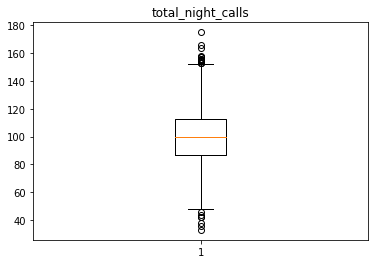

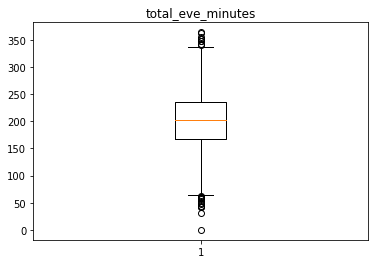

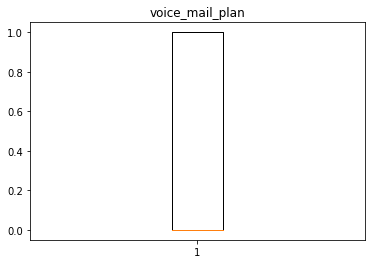

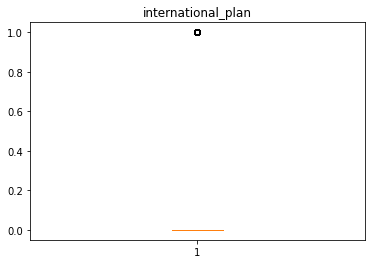

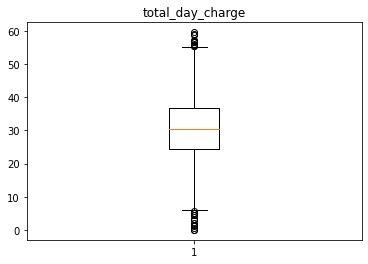

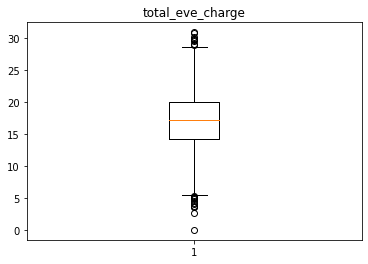

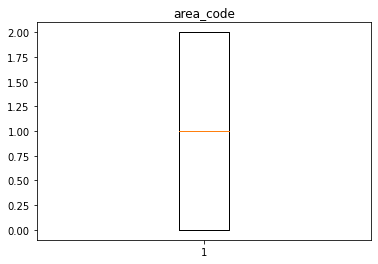

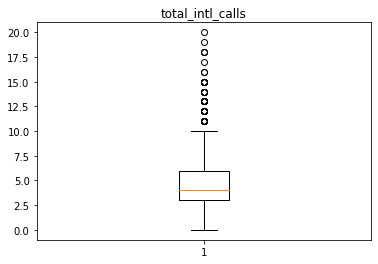

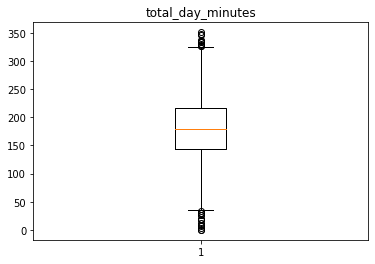

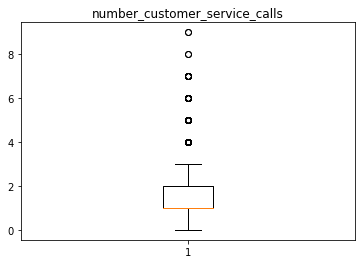

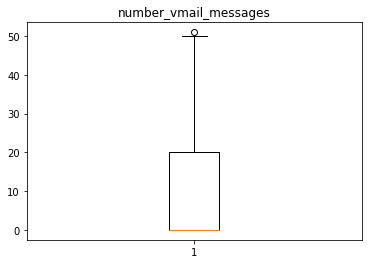

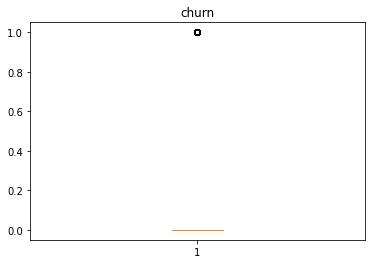

In [31]:
for col in melhoresColunas:
    plt.title(col)
    plt.boxplot(datasetTreino[col])
    plt.show()

### Tratando os outliers

In [32]:
colunasComOutliers = ["total_intl_calls" , "total_eve_charge", "number_customer_service_calls", "total_day_charge",
                     "total_night_calls", "total_eve_minutes", "total_day_minutes"]

for col in colunasComOutliers:
    media = datasetTreino[col].mean()
    std = datasetTreino[col].std()
    
    indicesSup = datasetTreino[datasetTreino[col] > (media + 2*std)].index
    indicesInf = datasetTreino[datasetTreino[col] < (media - 2*std)].index
    indices = list(set(list(indicesSup) + list(indicesInf)))
    
    datasetTreino[col].drop(index=indices, inplace = True)

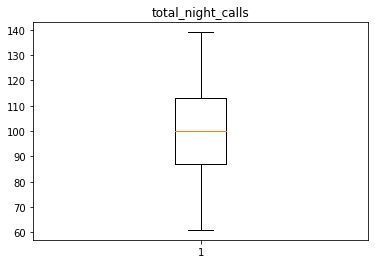

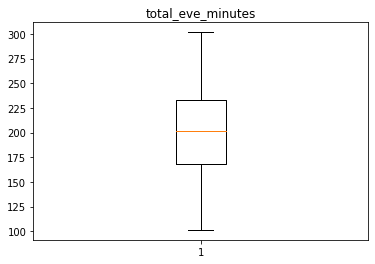

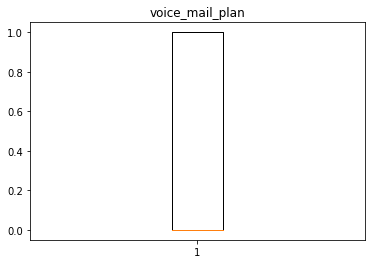

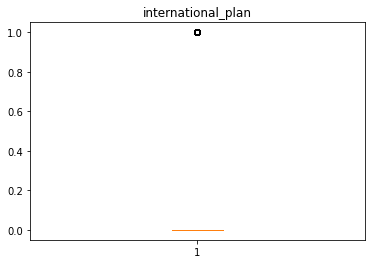

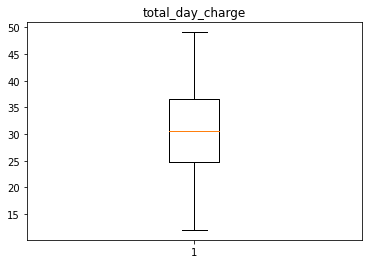

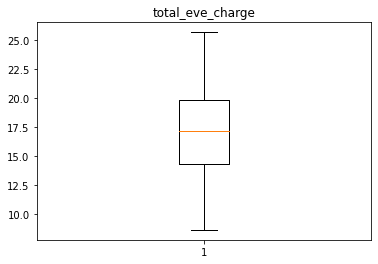

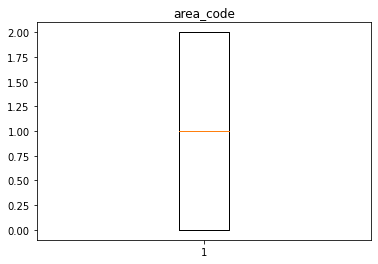

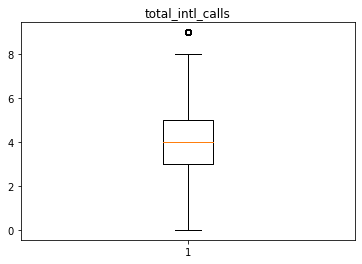

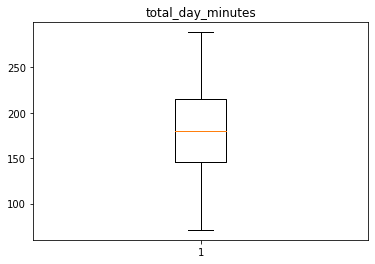

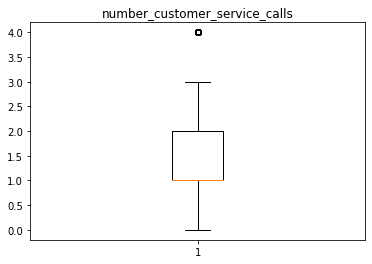

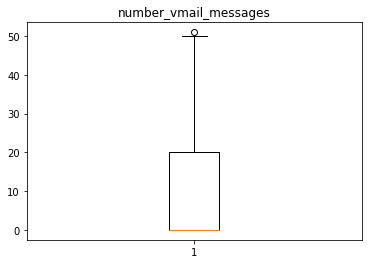

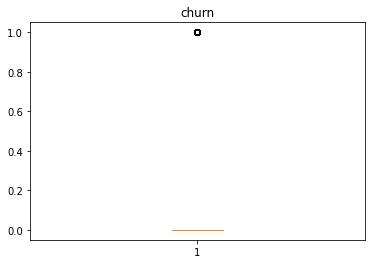

In [33]:
for col in melhoresColunas:
    plt.title(col)
    plt.boxplot(datasetTreino[col])
    plt.show()

### Padronizando os dados

In [34]:
scaler = RobustScaler()

colunasParaPadronizar = list(colunasFloat) + colunasInt

padronizedData = pd.DataFrame(scaler.fit_transform(datasetTreino[colunasParaPadronizar]), columns=colunasParaPadronizar)

padronizedDataTest = pd.DataFrame(scaler.fit_transform(datasetTeste[colunasParaPadronizar]), columns=colunasParaPadronizar)

In [35]:
for col in colunasParaPadronizar:
    datasetTreino[col] = padronizedData[col]
    datasetTeste[col] = padronizedDataTest[col]

### Aplicando oneHotEnconding

In [36]:
# Dados de treino
colunasInt = list(datasetTreino[melhoresColunas].select_dtypes(['int']).columns)
colunasInt.remove('churn')

encoder = OneHotEncoder()

newdata = (encoder.fit_transform(datasetTreino[colunasInt])).toarray()

NovaColunas = []
for col in encoder.get_feature_names():
    newcolumnName = colunasInt[int(col[1])] + '_' + col[3]
    NovaColunas.append(newcolumnName)
    

indice = 0
for col in NovaColunas:
    datasetTreino[col] = newdata[:, indice]
    indice = indice + 1
    
datasetTreino.drop(colunasInt, axis = 1, inplace = True)

In [37]:
# dados de teste
encoder = OneHotEncoder()

newdata = (encoder.fit_transform(datasetTeste[colunasInt])).toarray()

NovaColunasTest = []
for col in encoder.get_feature_names():
    newcolumnName = colunasInt[int(col[1])] + '_' + col[3]
    NovaColunasTest.append(newcolumnName)
    

indice = 0
for col in NovaColunas:
    datasetTeste[col] = newdata[:, indice]
    indice = indice + 1
    
datasetTeste.drop(colunasInt, axis = 1, inplace = True)

In [38]:
for c in colunasInt:
    melhoresColunas.remove(c)

melhoresColunas = melhoresColunas + NovaColunas

In [39]:
datasetTreino[melhoresColunas].describe()

,total_night_calls,total_eve_minutes,total_day_charge,total_eve_charge,area_code,total_intl_calls,total_day_minutes,number_customer_service_calls,number_vmail_messages,churn,voice_mail_plan_0,voice_mail_plan_1,international_plan_0,international_plan_1
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.004143,-0.006108,0.005041,-0.006243,0.000300,0.159816,0.005160,0.562856,0.404950,0.144914,0.723372,0.276628,0.903090,0.096910
std,0.752639,0.738193,0.749145,0.738128,0.354824,0.820405,0.749208,1.315491,0.684418,0.352067,0.447398,0.447398,0.295879,0.295879
min,-2.576923,-2.931587,-2.467638,-2.931507,-0.500000,-1.333333,-2.467675,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.500000,-0.506550,-0.491100,-0.506849,-0.500000,-0.333333,-0.491059,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.500000,0.493450,0.508900,0.493151,0.500000,0.666667,0.508941,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,2.884615,2.362445,2.357605,2.361301,0.500000,5.333333,2.357634,8.000000,2.550000,1.000000,1.000000,1.000000,1.000000,1.000000


### Separando os dados em treino e teste e balanceando eles

In [40]:
X = datasetTreino[melhoresColunas].drop(['churn'], axis = 1)
y = datasetTreino[melhoresColunas].churn

In [41]:
# separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [42]:
# balanceando os dados
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

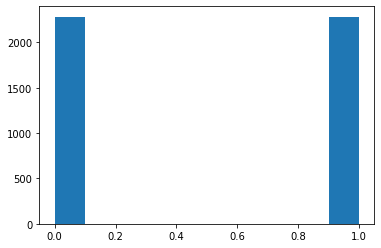

In [43]:
plt.hist(y_resampled)

plt.show()

### Treinando o modelo

In [44]:
weight = 1
weights = {0:1, 1:weight}
modelo = LogisticRegression(random_state=101, max_iter=500, class_weight=weights)

modelo.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=101, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
previsaoProb = modelo.predict_proba(X_test)
previsao = modelo.predict(X_test)

previsaoDF = pd.DataFrame(previsaoProb, columns=modelo.classes_)

In [46]:
previsaoDF

,0,1
0,0.533516,0.466484
1,0.917256,0.082744
2,0.819091,0.180909
3,0.563833,0.436167
4,0.823456,0.176544
...,...,...
662,0.523460,0.476540
663,0.774593,0.225407
664,0.912558,0.087442
665,0.841494,0.158506


### Avaliando o modelo

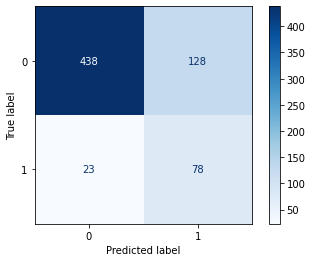

In [47]:
plot_confusion_matrix(modelo, X_test, y_test,
                      values_format='d',
                      cmap=plt.cm.Blues)

plt.show()

In [48]:
print(classification_report(y_test, previsao))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       566
           1       0.38      0.77      0.51       101

    accuracy                           0.77       667
   macro avg       0.66      0.77      0.68       667
weighted avg       0.86      0.77      0.80       667



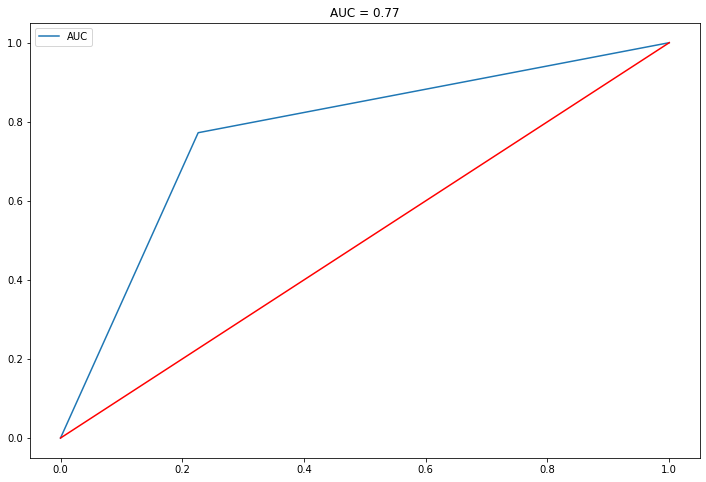

In [49]:
# curva ROC
plot_curveROC(y_test, previsao)

### Aplicando o modelo aos dados de teste

In [50]:
teste_x = datasetTeste[melhoresColunas].drop(['churn'], axis = 1)
teste_y = datasetTeste[melhoresColunas].churn

resultado = modelo.predict(teste_x)

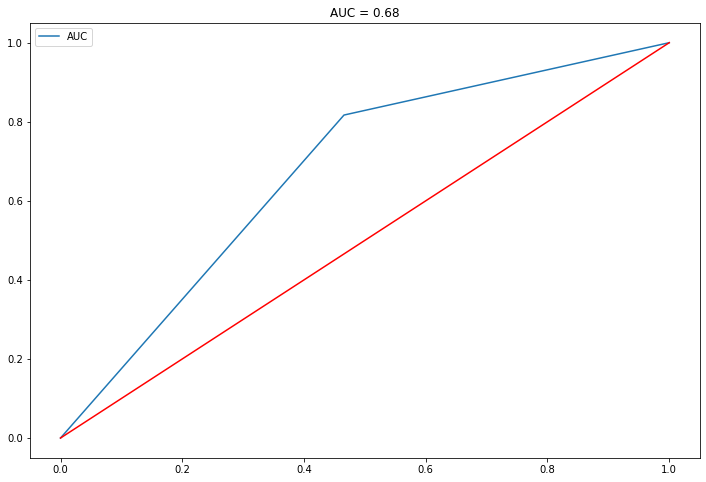

In [51]:
plot_curveROC(teste_y, resultado)

## Conclusão: 
### O modelo não generalizou bem. Ele previu, relativamente, bem os clientes que não sairão da empresa, mas os clientes que não são leais a marca ele não apresentou boa performance.

# FIM